In [1]:
import cv2 as cv 
import matplotlib.pyplot as plt

In [2]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb") #weights

In [3]:
inWidth= 368
inHeight = 368
thr = 0.2

In [4]:
 BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [5]:
img= cv.imread("pose.jpg")

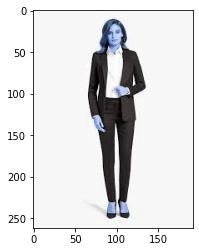

In [6]:
plt.imshow(img)

In [11]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5),swapRB=True, crop=False))#configuring the net loaded 
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)#local maxima
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    return frame

In [12]:
estimation = pose_estimation(img)

In [13]:
print(heatMap)


NameError: name 'heatMap' is not defined

In [14]:
lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
a_component = lab[:,:,1]
th = cv.threshold(a_component,140,255,cv.THRESH_BINARY)[1]

In [15]:
blur = cv.GaussianBlur(th,(13,13), 11)

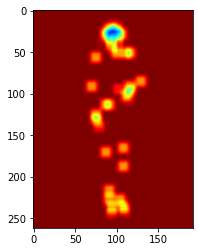

In [16]:
heatmap_img = cv.applyColorMap(blur, cv.COLORMAP_JET)
plt.imshow(heatmap_img)

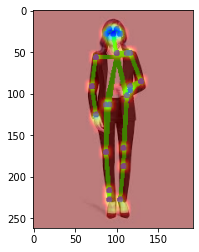

In [17]:
super_imposed_img = cv.addWeighted(heatmap_img, 0.5, img, 0.5, 0)
plt.imshow(super_imposed_img)

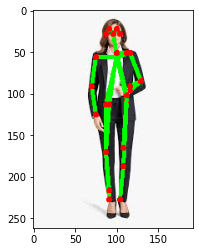

In [18]:
plt.imshow(cv.cvtColor(estimation, cv.COLOR_BGR2RGB))

#FOR WEBCAM


In [ ]:
cap= cv.VideoCapture(1)

cap.set(cv.CAP_PROP_FPS, 20)
cap.set(3,800)#height 
cap.set(2,1000)#width


if not cap.isOpened():
    cap=cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while cv.waitKey(1)<0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5),swapRB=True, crop=False))#255/2=127.5
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap) #local maxima
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            
    cv.imshow('Pose Estimation webcam', frame)
    
    


In [48]:
cap.release()
cv.destroyAllWindows()

#FOR VIDEO

In [19]:
cap= cv.VideoCapture('vidExample.mp4')
cap.set(3,800)
cap.set(4,800)
if not cap.isOpened():
    cap=cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open video")

while cv.waitKey(1)<0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
        
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5),swapRB=True, crop=False))#255/2=127.5
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)#local maxima
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    cv.imshow('Pose Estimation Video', frame)
    
    


In [20]:
cap.release()
cv.destroyAllWindows()